# 3D Kelvin Helmholtz Instability

## Imports

In [63]:
# %pip install ../

# numerics
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

# timing
from timeit import default_timer as timer

# plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# fluids
from jf1uids import SimulationConfig
from jf1uids import get_helper_data
from jf1uids import SimulationParams
from jf1uids import time_integration
from jf1uids.fluid_equations.fluid import construct_primitive_state3D

from jf1uids import get_registered_variables


## Initiating the stellar wind simulation

In [64]:
from jf1uids.option_classes.simulation_config import BACKWARDS


print("👷 Setting up simulation...")

# simulation settings
gamma = 5/3

# spatial domain
box_size = 1.0
num_cells = 150

fixed_timestep = False
scale_time = False
dt_max = 0.1
num_timesteps = 2000

# setup simulation config
config = SimulationConfig(
    runtime_debugging = False,
    first_order_fallback = True,
    dimensionality = 3,
    num_ghost_cells = 1,
    box_size = box_size, 
    num_cells = num_cells,
    fixed_timestep = fixed_timestep,
    differentiation_mode = BACKWARDS,
    num_timesteps = num_timesteps
)

helper_data = get_helper_data(config)

params = SimulationParams(
    t_end = 1,
    C_cfl = 0.4
)

registered_variables = get_registered_variables(config)

👷 Setting up simulation...


## Setting the initial state

In [65]:
from jax.random import PRNGKey, uniform

# Set the random seed for reproducibility
key = PRNGKey(0)

# Grid size and configuration
num_cells = config.num_cells
x = jnp.linspace(0, 1, num_cells)
y = jnp.linspace(0, 1, num_cells)
z = jnp.linspace(0, 1, num_cells)
X, Y, Z = jnp.meshgrid(x, y, z, indexing="ij")

# Initialize density
rho = jnp.where(Y > 0.5, 0.125, 1.0)  # Denser fluid below, lighter fluid above

# Initialize velocities
# Shear flow along x-direction with a random perturbation to trigger instability
v0 = 0.5
delta_v = 1.0  # Amplitude of velocity perturbation
u_x = jnp.where(Y > 0.5, v0, -v0) + delta_v * (uniform(key, shape=(num_cells, num_cells, num_cells)) - 0.5)
u_y = jnp.zeros_like(u_x)  # No initial velocity in y
u_z = jnp.zeros_like(u_x)  # No initial velocity in z

# Initialize pressure
p = jnp.ones((num_cells, num_cells, num_cells)) * 0.1

# Add a smooth transition (tanh) to avoid discontinuities in the initial condition
transition_width = 0.05
rho = 0.5 * (1.0 + jnp.tanh((0.5 - jnp.abs(Y - 0.5)) / transition_width)) * (1.0 - 0.125) + 0.125
u_x = u_x * (1.0 + 0.5 * (1.0 - jnp.tanh((0.5 - jnp.abs(Y - 0.5)) / transition_width)))

# initial state
initial_state = construct_primitive_state3D(rho, u_x, u_y, u_z, p, registered_variables)

## Simulation and Gradient

In [66]:
final_state = time_integration(initial_state, config, params, helper_data, registered_variables)

## Visualization

### Cut

Text(0.5, 1.0, 'Pressure')

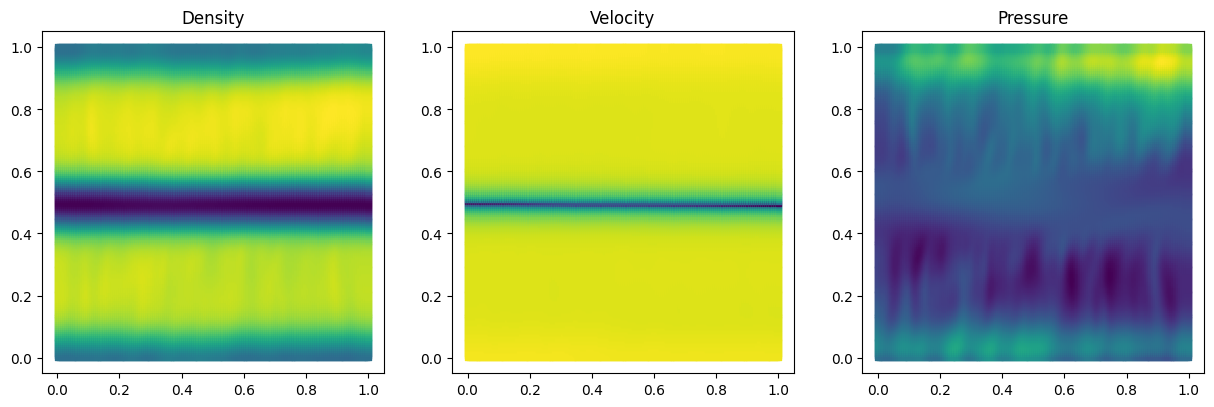

In [67]:
from matplotlib.colors import LogNorm

s = 15

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# equal aspect ratio
ax1.set_aspect('equal', 'box')
ax2.set_aspect('equal', 'box')
ax3.set_aspect('equal', 'box')

z_level = num_cells // 2

x = jnp.linspace(0, box_size, num_cells)
y = jnp.linspace(0, box_size, num_cells)

ym, xm = jnp.meshgrid(x, y)

# on the first axis plot the density
# log scaler
norm_rho = LogNorm(vmin = jnp.min(final_state[0, :, :, z_level]), vmax = jnp.max(final_state[0, :, :, z_level]), clip = True)
norm_p = LogNorm(vmin = jnp.min(final_state[4, :, :, z_level]), vmax = jnp.max(final_state[4, :, :, z_level]), clip = True)

ax1.scatter(xm.flatten(), ym.flatten(), c = final_state[0, :, :, z_level].flatten(), s = s, norm = norm_rho, marker = "s")
ax1.set_title("Density")

# on the second axis plot the absolute velocity
abs_vel = jnp.sqrt(final_state[1, :, :, z_level]**2 + final_state[2, :, :, z_level]**2 + final_state[3, :, :, z_level]**2)

vel_norm = LogNorm(vmin = jnp.min(abs_vel), vmax = jnp.max(abs_vel), clip = True)

ax2.scatter(xm.flatten(), ym.flatten(), c = abs_vel.flatten(), s = s, marker = "s", norm = vel_norm)
ax2.set_title("Velocity")

# on the third axis plot the pressure
ax3.scatter(xm.flatten(), ym.flatten(), c = final_state[4, :, :, z_level].flatten(), s = s, marker = "s") # , norm = norm_p)
ax3.set_title("Pressure")
